In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Places2

In [ ]:
import shutil 
shutil.unpack_archive("drive/MyDrive/Places2.zip", "Places2/")

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import pathlib

In [ ]:

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

In [ ]:
# Set the data dirs 

train_data_dir = '/content/Places2/Places2/train'  
validate_data_dir = '/content/Places2/Places2/val' 
test_data_dir = '/content/Places2/Places2/test'

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

train_data_dir = pathlib.Path(train_data_dir)
validate_data_dir = pathlib.Path(validate_data_dir)
test_data_dir = pathlib.Path(test_data_dir)

train_image_count = len(list(train_data_dir.glob('*/*.*')))
validate_image_count = len(list(validate_data_dir.glob('*/*.*')))
test_image_count = len(list(test_data_dir.glob('*/*.*')))


CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES
 

train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
validate_list_ds = tf.data.Dataset.list_files(str(validate_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

for f in train_list_ds.take(5):
  print(f.numpy())


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


# prepare the dataset with the labels and image as features
#Apply this function to each item in the dataset using the map method:
train = train_list_ds.map(process_path)
validation = validate_list_ds.map(process_path)
test = test_list_ds.map(process_path)

b'/content/Places2/Places2/train/outdoor/00000894.jpg'
b'/content/Places2/Places2/train/outdoor/00003695.jpg'
b'/content/Places2/Places2/train/outdoor/00000259.jpg'
b'/content/Places2/Places2/train/indoor/00003015.jpg'
b'/content/Places2/Places2/train/indoor/00000025 (10).jpg'


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 256, 256, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(2 , activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
validation_steps=5

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

5/5 [==============================] - 7s 1s/step - loss: 0.7677 - accuracy: 0.5312


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.53


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
182/182 [==============================] - 289s 2s/step - loss: 0.5775 - accuracy: 0.7569 - val_loss: 0.4530 - val_accuracy: 0.8707
Epoch 2/10
182/182 [==============================] - 284s 2s/step - loss: 0.3933 - accuracy: 0.8830 - val_loss: 0.3446 - val_accuracy: 0.8886
Epoch 3/10
182/182 [==============================] - 283s 2s/step - loss: 0.3169 - accuracy: 0.8980 - val_loss: 0.3018 - val_accuracy: 0.8913
Epoch 4/10
182/182 [==============================] - 283s 2s/step - loss: 0.2818 - accuracy: 0.9044 - val_loss: 0.2781 - val_accuracy: 0.8982
Epoch 5/10
182/182 [==============================] - 282s 2s/step - loss: 0.2611 - accuracy: 0.9088 - val_loss: 0.2653 - val_accuracy: 0.9017
Epoch 6/10
182/182 [==============================] - 281s 2s/step - loss: 0.2475 - accuracy: 0.9112 - val_loss: 0.2572 - val_accuracy: 0.9023
Epoch 7/10
182/182 [==============================] - 281s 2s/step - loss: 0.2381 - accuracy: 0.9135 - val_loss: 0.2521 - val_accuracy: 0.8989

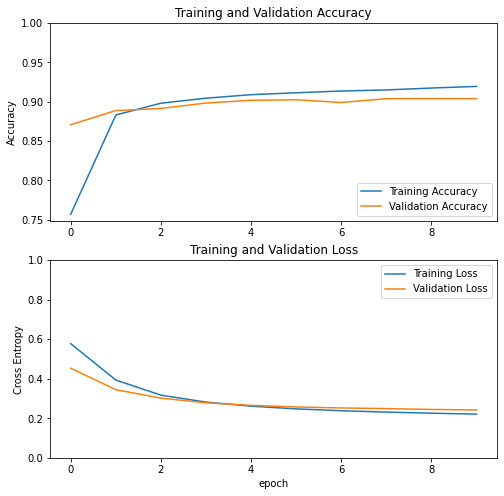

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
182/182 [==============================] - 489s 3s/step - loss: 0.2565 - accuracy: 0.9018 - val_loss: 0.2283 - val_accuracy: 0.9065
Epoch 11/20
182/182 [==============================] - 482s 3s/step - loss: 0.2036 - accuracy: 0.9236 - val_loss: 0.2209 - val_accuracy: 0.9092
Epoch 12/20
182/182 [==============================] - 482s 3s/step - loss: 0.1809 - accuracy: 0.9320 - val_loss: 0.2194 - val_accuracy: 0.9092
Epoch 13/20
182/182 [==============================] - 483s 3s/step - loss: 0.1639 - accuracy: 0.9372 - val_loss: 0.2190 - val_accuracy: 0.9154
Epoch 14/20
182/182 [==============================] - 488s 3s/step - loss: 0.1368 - accuracy: 0.9539 - val_loss: 0.2194 - val_accuracy: 0.9195
Epoch 15/20
182/182 [==============================] - 487s 3s/step - loss: 0.1279 - accuracy: 0.9536 - val_loss: 0.2197 - val_accuracy: 0.9188
Epoch 16/20
182/182 [==============================] - 480s 3s/step - loss: 0.1007 - accuracy: 0.9663 - val_loss: 0.2201 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


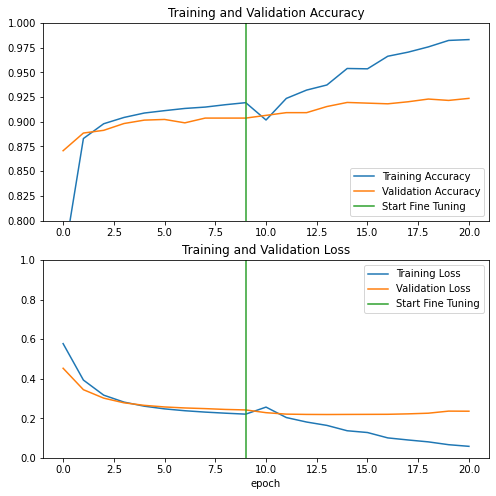

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/Places2/Places2/placesMobilnet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.save_weights(filepath='/content/Places2/Places2/final_weightVGGplaces.hdf5')

In [ ]:
loss1,accuracy1 = model.evaluate(test_batches, steps = validation_steps)
print("test loss: {:.2f}".format(loss1))
print("test accuracy: {:.2f}".format(accuracy1))

5/5 [==============================] - 6s 1s/step - loss: 0.1972 - accuracy: 0.9187
test loss: 0.20
test accuracy: 0.92


In [ ]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("/content/Places2/Places2/placesMobilnet.h5")

    # image path
    #img_path = '/content/Places2/Places2/val/indoor/00000003 (3).jpg'   
    img_path = '/content/Places2/Places2/val/outdoor/00000064.jpg'      

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict_classes(new_image)

if pred==0:
  print("indoor")
else:
  print("outdoor")


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


outdoor
